<a href="https://colab.research.google.com/github/ethamCS/Bert-Medical-Apps/blob/main/nlpaug_initial_labeled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sat Aug 19 01:49:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.9 MB/s eta 0:00:00


In [ ]:
!pip install nlpaug

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 3.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

In [ ]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
%config InlineBackend.figure_format='retina'
RANDOM_SEED = 42
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
sns.set_palette(sns.color_palette("crest"))
rcParams['figure.figsize'] = 12, 8

In [ ]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas

In [ ]:
import pandas as pd
df = pd.read_csv('/content/100_labeled.csv')
df

,app_id,description,label
0,com.genius.gifMaster.gp,Introducing the ultimate GIF-making tool - Gif...,0
1,com.affecttherapeutics,Affect is more than a sobriety app or sober tr...,1
2,com.google.android.apps.dynamite,Google Chat is an intelligent and secure commu...,0
3,com.labcorp.patientportal,The Labcorp Patient mobile app is easy to use ...,1
4,com.facebook.lite,Keeping up with friends is faster and easier t...,0
...,...,...,...
195,NaN,We‚Äôre committed to your safety at Uber. We‚Ä...,0
196,NaN,Learn a new language with the world‚Äôs most-d...,0
197,NaN,"VIRTUAL PRIMARY CARE, 24/7 ACCESS TO DOCTORS, ...",1
198,NaN,WhatsApp Business from Meta WhatsApp Business ...,0


In [ ]:
df = df.drop(columns=['app_id'])


In [ ]:
from sklearn.model_selection import train_test_split
# train, test = train_test_split(df, test_size=0.3, stratify=df.iloc[:,10])
train, test = train_test_split(df, test_size=0.5, random_state=42)

In [ ]:
print("train Size : {} ".format(train.shape))
print("test Size : {} ".format(test.shape))

train Size : (100, 2) 
test Size : (100, 2) 


In [ ]:
def plot(df, title):
  label_counts = df['label'].value_counts()
  sns.set_style("whitegrid")
  plt.figure(figsize=(8, 6))
  sns.barplot(x=label_counts.index, y=label_counts.values)
  plt.title(title)
  plt.xlabel("Label")
  plt.ylabel("Count")
  plt.xticks(label_counts.index, ["Label 0", "Label 1"])
  plt.show()

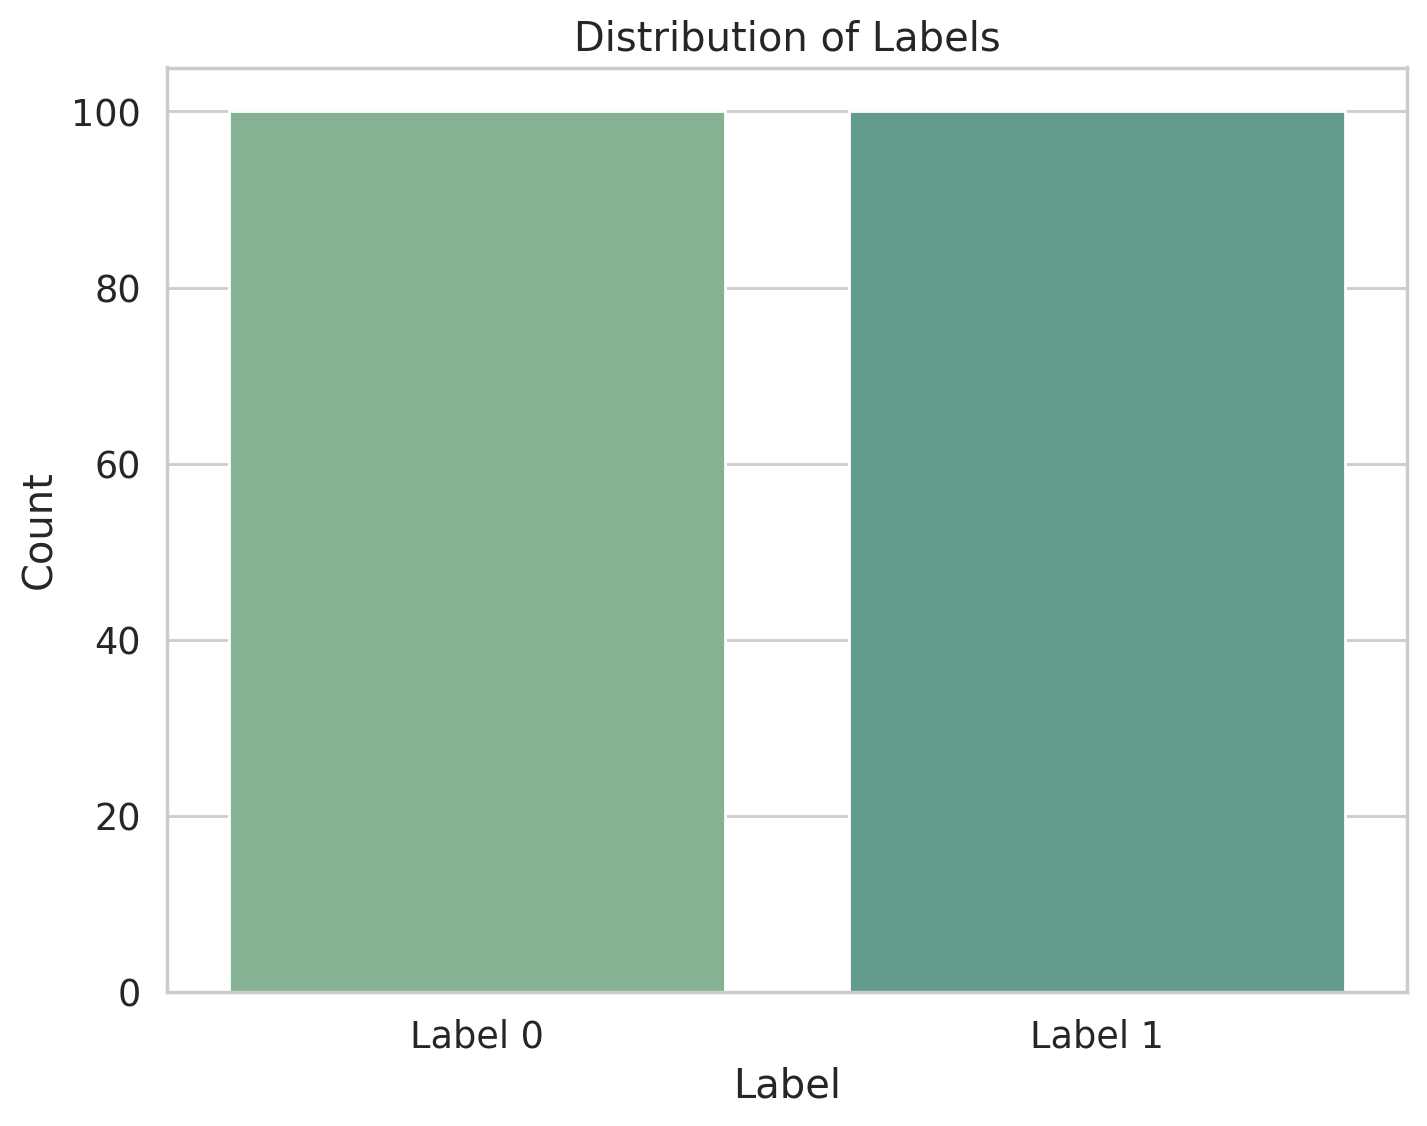

In [ ]:
plot(df,"Distribution of Labels")

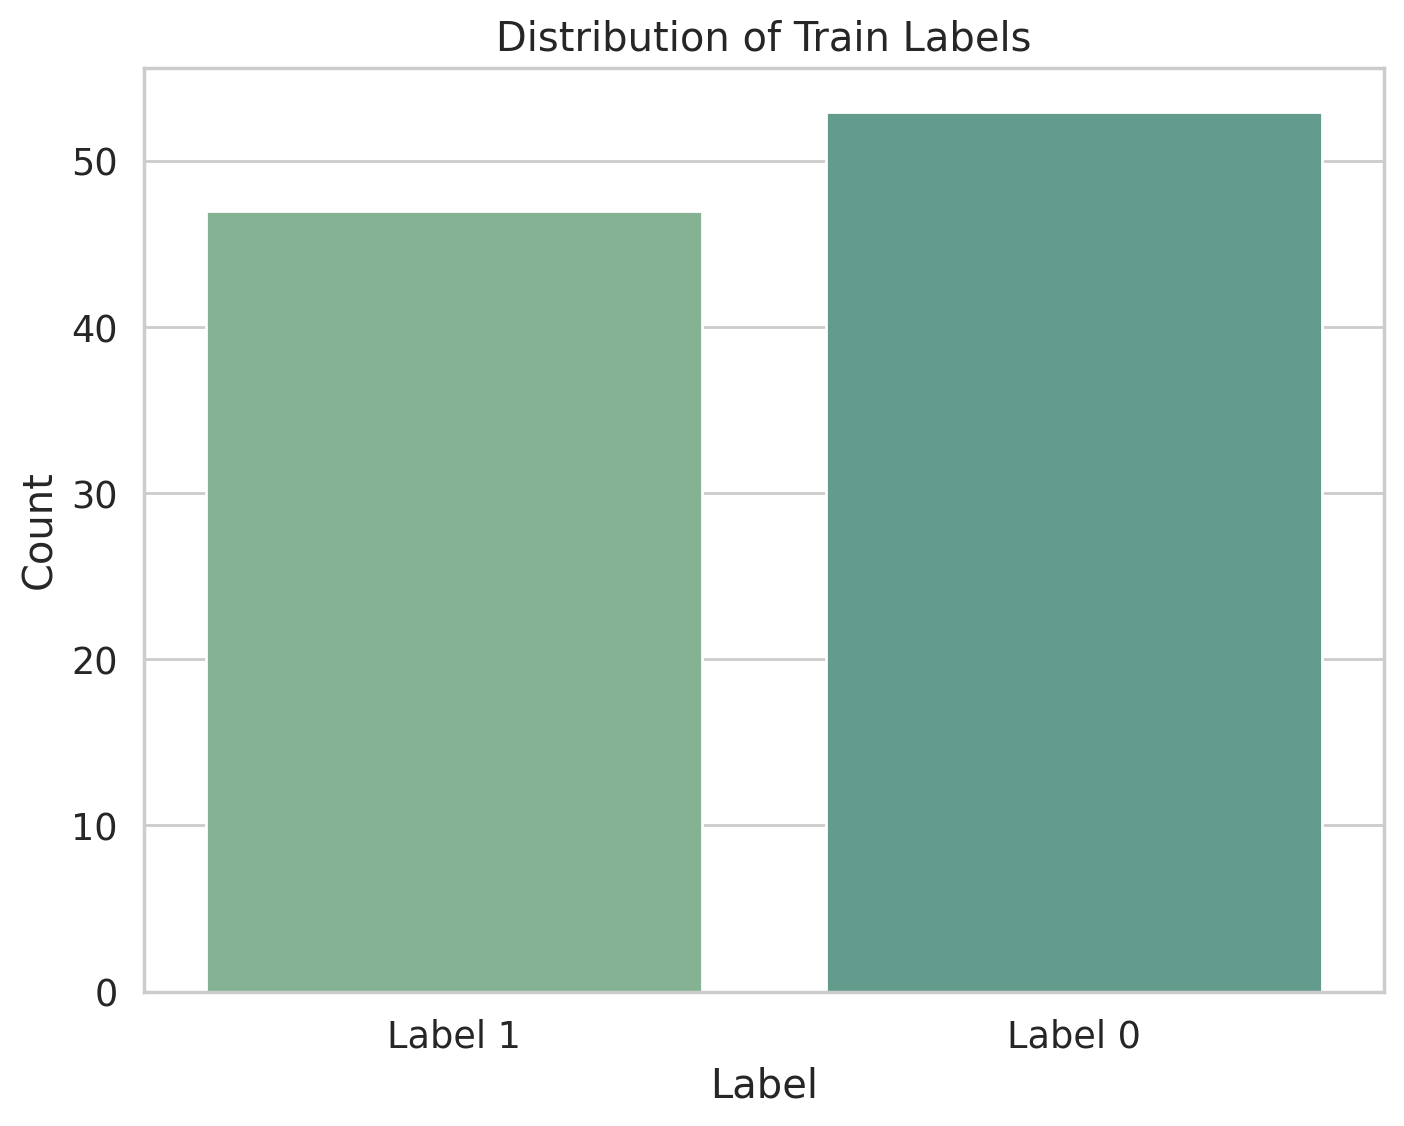

In [ ]:
plot(train, "Distribution of Train Labels")

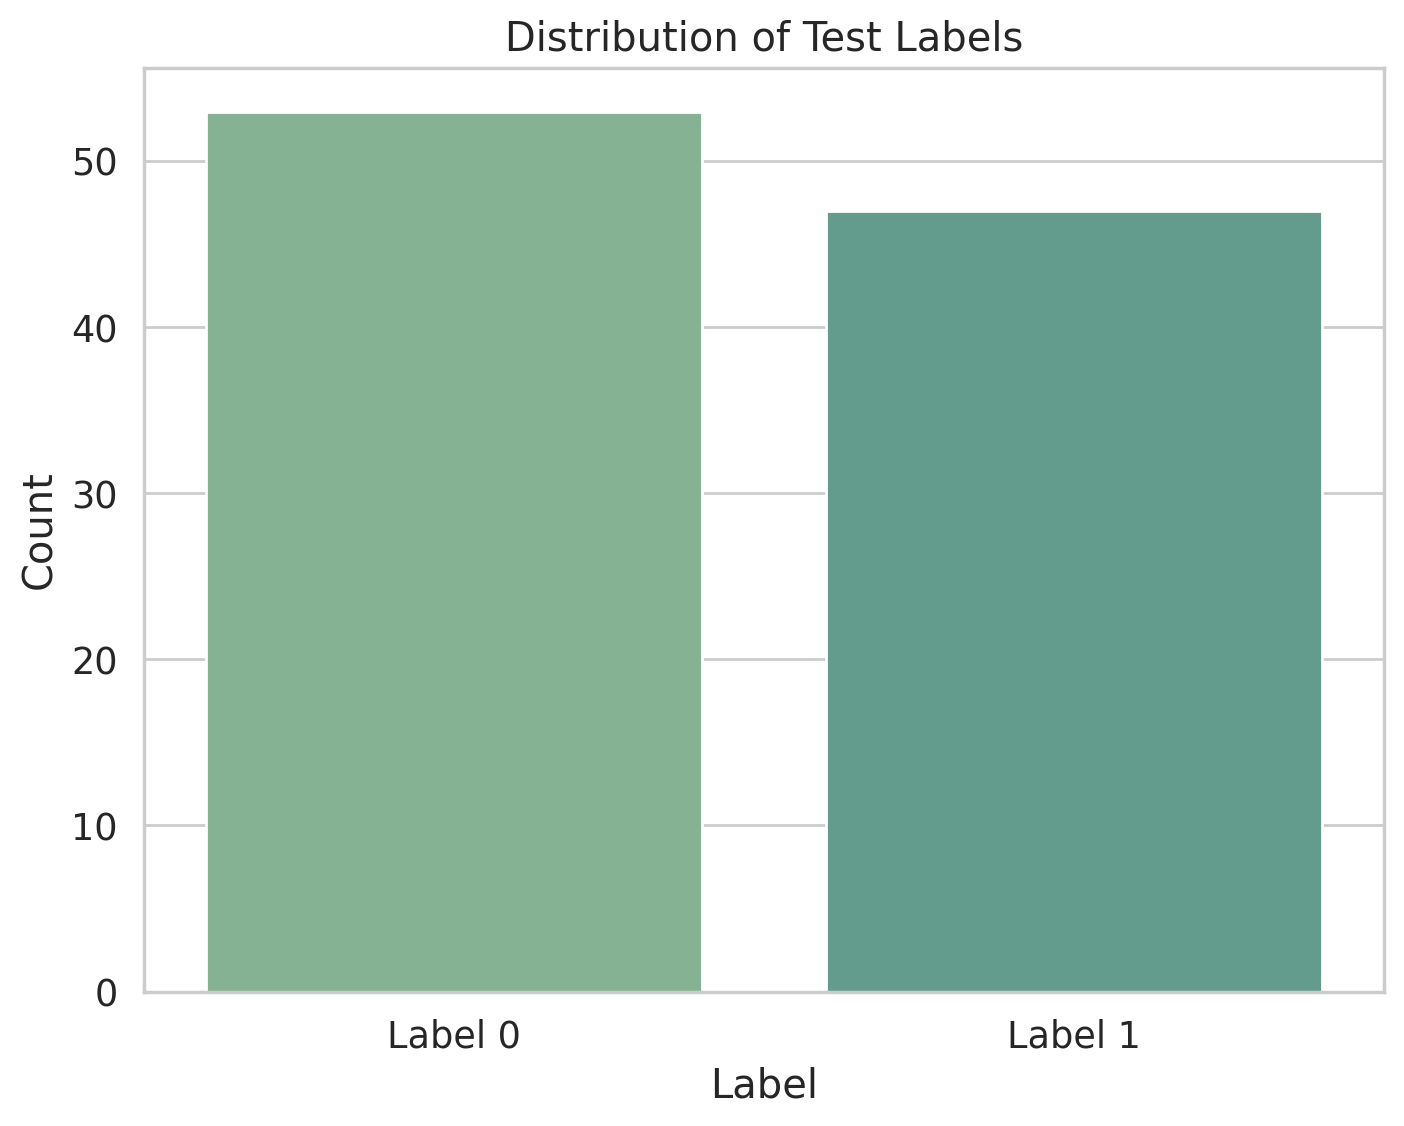

In [ ]:
plot(test, "Distribution of Test Labels")

In [ ]:
pd.options.mode.chained_assignment = None
TOPK=20
ACT = 'substitute'

aug_bert = naw.ContextualWordEmbsAug(
    model_path='bert-base-uncased',
    device='cuda',
    action=ACT, top_k=TOPK)

count1= 0

for index, row in train.iterrows():
    bounds = 4
    test_sentence = row['description']
    test_sentence_label = row['label']

    for ii in range(bounds):

        augmented_text = aug_bert.augment(test_sentence)
        # print(augmented_text)
        dict_1 = {
            'description': augmented_text[0],
            'label': test_sentence_label
        }

        new_df = pd.DataFrame([dict_1])

        train = pd.concat([
            new_df,
            train
            ]
        )

        count1 = count1+ 1

    if count1 % 100 == 0:
      print(f'number of augmented senteces; {count1}')

print(f'final number of augmented senteces; {count1}')

number of augmented senteces; 100
number of augmented senteces; 200
number of augmented senteces; 300
number of augmented senteces; 400
final number of augmented senteces; 400


In [ ]:
train.shape

(500, 2)

In [ ]:
train.to_csv('/content/train_400.csv')

In [ ]:
test.to_csv('/content/test_100_2.csv')